In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc

# !pip -q install yfinance

import yfinance as yf


# **Predicting next-day stock direction via SVM: Yahoo Finance data**

We will download AAPL daily price data from Yahoo Finance, engineer simple return-based features, and use an SVM classifier (RBF kernel) to predict whether the *next-day* return is positive or negative.

## Load data and pre-processing

We use **AAPL** daily data from Yahoo Finance. You can switch to another ticker by changing `ticker` below.

In [ ]:
ticker = "AAPL"
start = "2015-01-01"
end = None  # use today's date

df = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)
df = df.dropna()
df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.214897,24.682230,23.776357,24.671155,212818400
2015-01-05,23.532721,24.064284,23.346674,23.984549,257142000
2015-01-06,23.534931,23.794068,23.173911,23.596947,263188400
2015-01-07,23.864948,23.964616,23.632389,23.743131,160423600
2015-01-08,24.781891,24.839477,24.075355,24.192743,237458000


In [ ]:
df.columns = df.columns.get_level_values(0)

In [ ]:
# Feature engineering: use lagged returns and rolling statistics
data = df.copy()
data["Return"] = data["Close"].pct_change()

# Lagged returns
for k in range(1, 6):
    data[f"Lag{k}"] = data["Return"].shift(k)

# Rolling features (computed using only past info)
data["MA5"] = data["Close"].rolling(5).mean()
data["MA10"] = data["Close"].rolling(10).mean()
data["Vol10"] = data["Return"].rolling(10).std()

# Normalize moving averages into relative terms
data["MA5_ratio"] = data["Close"] / data["MA5"] - 1
data["MA10_ratio"] = data["Close"] / data["MA10"] - 1

# Label: next-day direction (1 for up, -1 for down)
data["NextReturn"] = data["Return"].shift(-1)
data["Direction"] = np.where(data["NextReturn"] > 0, 1, -1)

# Final dataset
feature_cols = [f"Lag{k}" for k in range(1, 6)] + ["MA5_ratio", "MA10_ratio", "Vol10"]
dataset = data[feature_cols + ["Direction"]].dropna()
dataset.head()


Price,Lag1,Lag2,Lag3,Lag4,Lag5,MA5_ratio,MA10_ratio,Vol10,Direction
Date,,,,,,,,,
2015-01-16,-0.027141,-0.003811,0.008879,-0.024641,0.001073,-0.022377,-0.024249,0.020765,1
2015-01-20,-0.007770,-0.027141,-0.003811,0.008879,-0.024641,0.003785,-0.001387,0.020475,1
2015-01-21,0.025757,-0.007770,-0.027141,-0.003811,0.008879,0.012701,0.003205,0.020516,1
2015-01-22,0.007634,0.025757,-0.007770,-0.027141,-0.003811,0.034077,0.024940,0.021541,1
2015-01-23,0.026016,0.007634,0.025757,-0.007770,-0.027141,0.027764,0.029206,0.017986,1


In [ ]:
# check whether data is imbalanced
unique, counts = np.unique(y, return_counts=True)
print(counts)

[1308 1479]


## Use SVM to predict next-day direction

We split the data in time order (first 70% for training, last 30% for testing). This avoids training on the future and testing on the past.

In [ ]:
X = dataset[feature_cols].values
y = dataset["Direction"].values

n = len(dataset)
split = int(0.7 * n)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train.shape, X_test.shape

((1950, 8), (837, 8))

In [ ]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_sc[:3]

array([[-1.51476270e+00, -2.61484727e-01,  4.19708367e-01,
        -1.37968246e+00,  2.72342538e-05, -1.26387970e+00,
        -9.77760466e-01,  4.79112931e-01],
       [-4.74149059e-01, -1.51479395e+00, -2.62024841e-01,
         4.20247275e-01, -1.38218257e+00,  1.00961027e-01,
        -1.92392745e-01,  4.47401159e-01],
       [ 1.32693081e+00, -4.74173875e-01, -1.51539617e+00,
        -2.61153777e-01,  4.19649716e-01,  5.66103487e-01,
        -3.46427036e-02,  4.51857548e-01]])

In [ ]:
# Tune gamma and C for RBF SVM using cross-validation on the training set
tuned_parameters_rbf = [{"kernel": ["rbf"],
                         "gamma": [1, 1e-1, 1e-2, 1e-3, 1e-4],
                         "C": [1, 10, 100, 1000, 10000]}]

svmCV = GridSearchCV(SVC(probability=True),
                     tuned_parameters_rbf,
                     scoring="roc_auc",
                     cv=5,
                     n_jobs=-1)

svmCV.fit(X_train_sc, y_train)

svmCV.best_params_, svmCV.best_score_

In [ ]:
# Predict test set labels
ypred_cv = svmCV.predict(X_test_sc)

print("Test accuracy:", accuracy_score(y_test, ypred_cv))
print("\nConfusion matrix:\n", confusion_matrix(y_test, ypred_cv))
print("\nClassification report:\n", classification_report(y_test, ypred_cv))

Test accuracy: 0.5352449223416965

Confusion matrix:
 [[  6 380]
 [  9 442]]

Classification report:
               precision    recall  f1-score   support

          -1       0.40      0.02      0.03       386
           1       0.54      0.98      0.69       451

    accuracy                           0.54       837
   macro avg       0.47      0.50      0.36       837
weighted avg       0.47      0.54      0.39       837



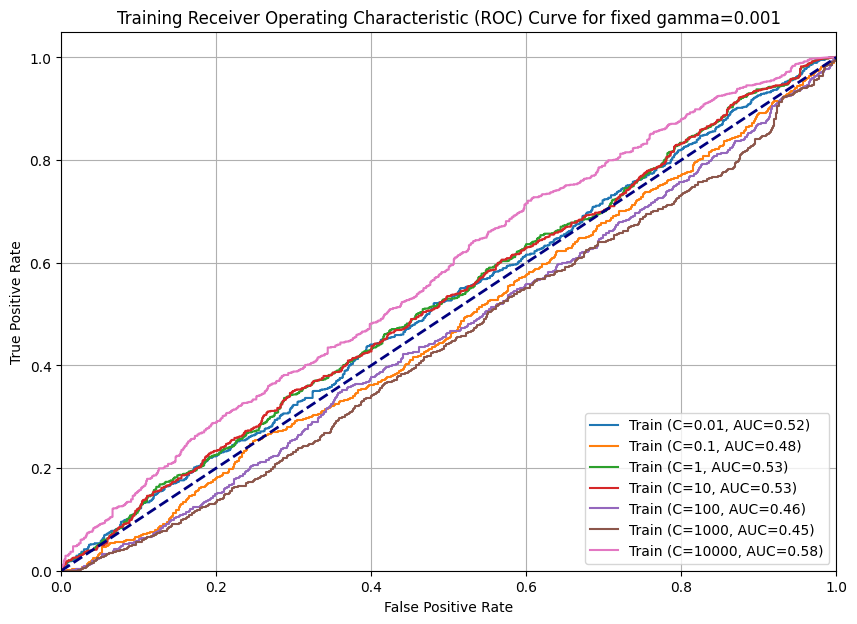

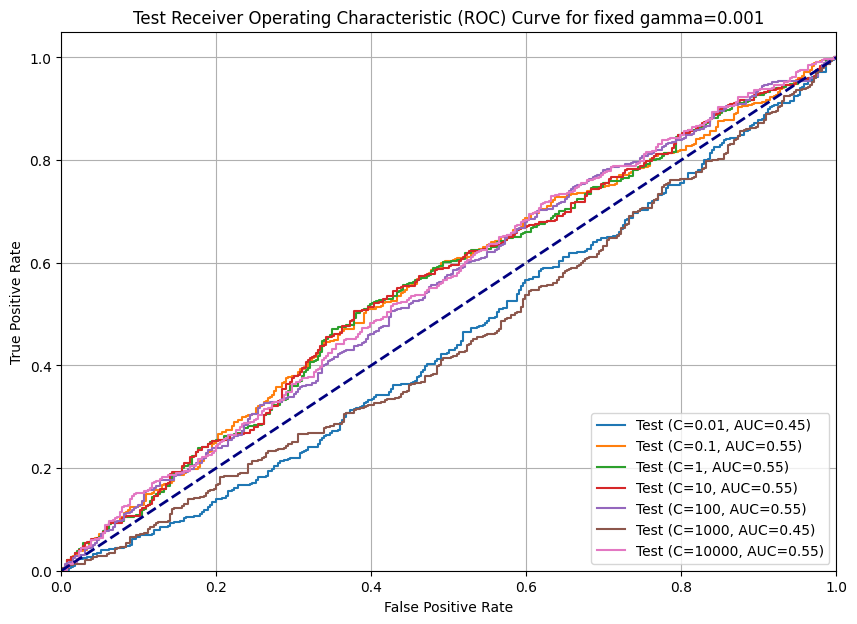

In [ ]:
best_gamma = svmCV.best_params_['gamma']

# Define different C values to test
C_values = [0.01, 0.1, 1, 10, 100, 1000, 10000]

# Create plot for Training ROC curves
plt.figure(figsize=(10, 7))
for C_val in C_values:
    # Train SVC with fixed gamma and current C
    svm_model = SVC(kernel='rbf', gamma=best_gamma, C=C_val, probability=True)
    svm_model.fit(X_train_sc, y_train)

    # Predict probabilities for ROC curve on training set
    y_train_pred_proba = svm_model.predict_proba(X_train_sc)[:, 1]

    # Calculate ROC curve and AUC for training set
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba, pos_label=1)
    auc_train = auc(fpr_train, tpr_train)

    # Plot ROC curve for the current C value on training set
    plt.plot(fpr_train, tpr_train, lw=1.5, label=f'Train (C={C_val}, AUC={auc_train:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Training Receiver Operating Characteristic (ROC) Curve for fixed gamma={best_gamma}')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Create plot for Test ROC curves
plt.figure(figsize=(10, 7))
for C_val in C_values:
    # Train SVC with fixed gamma and current C (re-training to ensure separate models if needed, though not strictly necessary here)
    svm_model = SVC(kernel='rbf', gamma=best_gamma, C=C_val, probability=True)
    svm_model.fit(X_train_sc, y_train)

    # Predict probabilities for ROC curve on test set
    y_test_pred_proba = svm_model.predict_proba(X_test_sc)[:, 1]

    # Calculate ROC curve and AUC for test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba, pos_label=1)
    auc_test = auc(fpr_test, tpr_test)

    # Plot ROC curve for the current C value on test set
    plt.plot(fpr_test, tpr_test, lw=1.5, label=f'Test (C={C_val}, AUC={auc_test:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Test Receiver Operating Characteristic (ROC) Curve for fixed gamma={best_gamma}')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()